In [1]:
%matplotlib inline
import numpy as np
import tensorflow as tf
import pylab
import matplotlib.pyplot as plt
from tensorflow.python.framework import ops
from tensorflow.python.ops import gen_nn_ops
from random import shuffle         # For shuffling start position list
from kernels import fac_kernel    # Factory Method which yields Kernel Object

import cPickle as pickle
import time
import scipy.optimize as opt

Dim. of X-data: 500 x 2
First 10 mean p: 
[ 0.564  0.464  0.484  0.496  0.426  0.514  0.58   0.526  0.516  0.53 ]
Dim. of Y-data: 500 x 100
Assumed f-mean:
[ 1.57079633  1.57079633  1.57079633  1.57079633  1.57079633  1.57079633
  1.57079633  1.57079633  1.57079633  1.57079633]


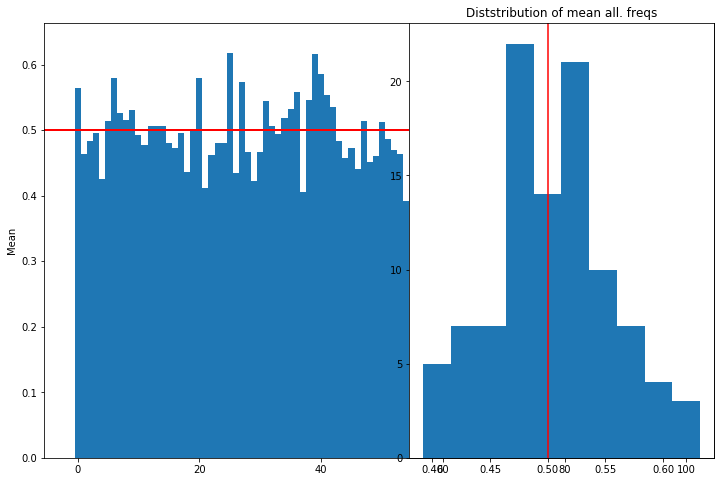

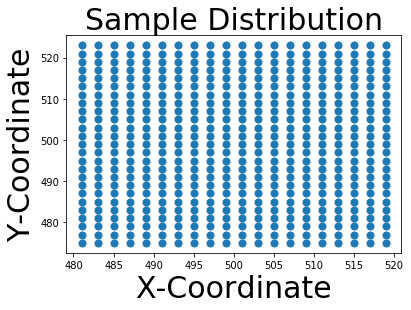

In [2]:
nr_inds = 500 # Nr. of Individuals to Check

kernel_type= "DiffusionK0"  #DiffusionK0 #DiffusionK0
X_data = np.loadtxt('./Data/coordinates5.csv', delimiter='$').astype('float64') # Load the complete X-Data
Y_data = np.loadtxt('./Data/data_genotypes5.csv', delimiter='$').astype('float64') # Load the complete Y-Data

#path1 = "data_lists.p"  # Load data from pickle file!
#x_data_sets, y_data_sets  = pickle.load(open(path1, "rb"))  # Load data from pickle file!
#print("Length of Data-Set: ")
#print(len(x_data_sets))
#data_set_nr=1
#X_data=x_data_sets[data_set_nr]
#Y_data=y_data_sets[data_set_nr]

#print(len(X_data))
inds=range(len(X_data))
shuffle(inds)  # Random permutation of the indices. If not random draw - comment out
inds=inds[:nr_inds]  # Only load first nr_inds


# Only load first nr_inds entries
X_data = X_data[inds,:]
Y_data = Y_data[inds,:]

#./data_genotypes5.csv has mean p=0.2
assert(len(X_data) == len(Y_data))

N = X_data.shape[0]
k = X_data.shape[1]
print("Dim. of X-data: %i x %i" % (N,k))
M1 = Y_data.shape[0]
nr_loci = Y_data.shape[1]


p_mean = np.mean(Y_data, axis=0) # Empirical average for every loci
#p_mean=np.mean(Y_data)
print("First 10 mean p: ")
print(p_mean[:10])

# Change this for coordinates5.csv  (If mean is known)
#f_mean = np.loadtxt('./mean_f6.csv', delimiter='$').astype('float64')[inds]   # Empirical f_mean
#f_mean = np.log(p_mean) - np.log(1 - p_mean) # Does a Logit Transform
#f_mean=np.log(0.2)-np.log(1.0-0.2)   # If known

#print(len(f_mean))
#print(len(f_mean))
Y_data[Y_data < 0.5] = -1.0  # For the logit Link function
print("Dim. of Y-data: %i x %i" % (M1, nr_loci))

#mean_paramss = np.array([f_mean for _ in range(nr_loci)]) # Initial Parameter for the mean-parameters
#mean_paramss = np.array([0.0 for _ in range(nr_loci)])  # Set everything to 0
mean_paramss = np.array([np.pi/2.0 for _ in range(nr_loci)])  # Set everything to 0.5. For ArcSin Model
mps = mean_paramss  # Just a short notation
#mean_paramss = np.array(f_mean)
print("Assumed f-mean:")
print(mps[:10])

# Plot the mean p-s:
fig=plt.figure(figsize=(12,8))
ax1=fig.add_subplot(111)
ax1.bar(range(len(p_mean)), p_mean, width=1.0)
ax1.set_ylabel("Mean")
ax1.axhline(y=0.5,c="r", linewidth=2)

ax2=fig.add_subplot(122)
ax2.hist(p_mean)
ax2.axvline(x=0.5, c="r")
plt.title("Diststribution of mean all. freqs")
plt.show()


# Plot the data
pylab.figure()
pylab.title("Sample Distribution", fontsize=30)
pylab.scatter(X_data[:,0], X_data[:,1], label = "Samples",s=50)
#pylab.vlines(0, min(X_data[:,1]), max(X_data[:,1]), linewidth=2, color="red", label="Barrier")
pylab.xlabel("X-Coordinate", fontsize=30)
pylab.ylabel("Y-Coordinate", fontsize=30)
#pylab.xlim([-22,22])
#pylab.ylim([-30,30])
#pylab.tick_params(axis='both', which='both', bottom='off', 
#                    top='off', labelbottom='off', right='off', left='off', labelleft='off')
#pylab.legend(fontsize=20)
pylab.show()

In [3]:
# From Alex: To calculate the log determinant

def py_func(func, inp, Tout, stateful=True, name=None, grad=None):
    
    # Need to generate a unique name to avoid duplicates:
    rnd_name = 'PyFuncGrad' + str(np.random.randint(0, 1E+8))
    
    tf.RegisterGradient(rnd_name)(grad)
    g = tf.get_default_graph()
    with g.gradient_override_map({"PyFunc": rnd_name}):
        return tf.py_func(func, inp, Tout, stateful=stateful, name=name)
    
def py_logdet(x, name=None):
    
    with ops.op_scope([x], name, "Logdet") as name:
        logdet = py_func(lambda x: np.linalg.slogdet(x)[1],
                         [x],
                         [tf.float64],
                         name=name,
                         grad=_LogdetGrad)  # <-- here's the call to the gradient
    return logdet[0]

def _LogdetGrad(op, grad):
    x = op.inputs[0]
    return tf.matrix_inverse(x) * grad[:, None, None]

In [4]:
# For sin^2(x/2) Link function
def link_f(f):   # Define Link function
    '''Sinus Squared Link function'''
    pi=0.999*np.pi*tf.ones((N, nr_loci), dtype=tf.float64)  # Matrix - for values bigger than Pi. 
    #Allow for values slightly smaller than Pi to infinte likelihood (to avoid infinities)
    z=0.001*tf.ones((N, nr_loci), dtype=tf.float64)       
    # Matrix - for values smaller than 0. Allow for small values slightly bigger than 1 (to avoid infinities)
    f=tf.where(f>np.pi, pi, f)       # Make values bigger than pi almost pi
    f=tf.where(f<0, z, f)            # Make values smaller than 0 almost 0
    
    y = tf.sin(0.5*f) ** 2        # Do the actual calculation
    return y

with tf.device('/gpu:0'):
    X = tf.Variable(dtype=tf.float64, initial_value = X_data, trainable=False)
    Y = tf.Variable(dtype=tf.float64, initial_value = Y_data, trainable=False)
    F = tf.Variable(dtype=tf.float64, initial_value = np.random.normal(0.0, 0.1, (N, nr_loci)).astype('float64'),
                    trainable=True)

    #hyper_params = tf.placeholder(shape = [3 + nr_loci], dtype=tf.float64)      # HyperParameters for the Kernel
    K0 = tf.placeholder(shape=[N,N], dtype = tf.float64)
    #hyper_params = tf.placeholder(shape=[4], dtype = tf.float64)                # The Kernel Hyper Parameters
    hyper_params_means =tf.placeholder(shape=[nr_loci], dtype = tf.float64)      # The Mean Hyper Parameters
    
    # First two are for the kernel; nr_loci are for the means of the GRFs!
    #mean_params = tf.placeholder(shape=[nr_loci], dtype=tf.float64)  # HyperParameters for the mean Values
    
    # Take Absolute Values - to avoid problems for negative values
    #a = tf.abs(hyper_params[0])           # The Parameter for the absolute correlation
    #l = tf.abs(hyper_params[1])           # The Parameter for the length scale
    #c = tf.abs(hyper_params[2])           # The Parameter for the Barrier strenght
    #sigma_sqrd = tf.abs(hyper_params[3])  # The Parameter for the overall deviation from the mean (Gaussian Model)
    
    #mean_param = hyper_params[3:]   # The mean parameters
    mean_param = hyper_params_means
    
    eye = tf.eye(N, dtype=tf.float64)

    # The Kernel for the classical Covariance Matrix
    #K = a * tf.exp(-tf.reduce_sum(((X[:, None] - X[None, :]) ** 2) / (2 * l**2), reduction_indices=[2])) + 0.00001*eye\
    #0.00001 * tf.eye(N, dtype=tf.float64) # Calculate Matrix of Covariances
    
    # The Kernel for the full covariance Matrix:
    #K1 = sigma_sqrd * tf.ones((nr_inds,nr_inds), dtype=tf.float64)  # Covariance Function due to deviations from mean
    #K = full_kernel_function(X, l, a, c, sigma_sqrd) + K1 + 0.00001 * eye # Add identity to make positive definite
    K = K0  # The full Kernel to use. Add identity to make positive definite: This already happens in the Kernel class now
    
    #K = rbf_kernel_function(X, l, a) + 0.00001 * eye  # Add identity to ensure positive definite
 
    
    f_tot = F + mean_param[None, :]    # Adds mean term; None is at position of an individual
    #f_tot= F + f_mean[None,:]          # Adds empirical mean term
    #f_tot = F + f_mean                 # For the case that there is a single Value
    p = link_f(f_tot)    # Calculate novel p, assuming sin^2 Link Function
    Kinv_F = tf.matrix_solve(K, F)      # Calculate K^(-1)*F
    
    g0 = tf.greater(Y, 0.5)        # Values where Y is greater than 0; i.e. data is 1.
    g0 = tf.cast(g0, tf.float64)   # Transform so that can be multiplied

    y_f= g0*p + (1-g0)*(1-p)  # Probability of observing y given probabilities p
    
    data_fit = tf.reduce_sum(tf.log(y_f), reduction_indices=[0])   # Calculate Data Fit: Check  
    prior_fit = -0.5 * tf.reduce_sum(F * Kinv_F, reduction_indices=[0])          # Calculate 1st term of prior probability: Check
    
    logL = tf.reduce_sum(data_fit + prior_fit) # Modulo terms not depending on f: Check
    
    d1 = 1.0/tf.tan(0.5*f_tot)   # Gradient coming from f_tot (for y=1)
    d0 = -tf.tan(0.5*f_tot)      # Gradient comfing from t_tot (for y=0)
    
    grad1 = g0*d1 + (1-g0)*d0  # First part of the gradient
    
    g =  grad1 - Kinv_F       # Calculate Matrix for Gradients Check
    
    h1 = -0.5 / ((tf.sin(0.5 * f_tot))**2) # Minus second derivative of data. (for y=1)
    h0 = -1.0 / (1 + tf.cos(f_tot))        # Second derivative of data (for y=0)
    W = - g0 * h1 - (1 - g0) * h0       # Calculate first part of Hessian. It is diagonal (but here diagonal in every column)
    
    lhs = -K[:, :, None] * W[None, :, :] - tf.eye(N, dtype=tf.float64)[:, :, None] # Check (HEAD-ACHE)
    #lhs = -K[:, :, None] * W[None, :, :] - eye[:, :, None] 
    rhs = tf.matmul(K, g)
    
    update = tf.matrix_solve(tf.transpose(lhs, [2, 0, 1]), tf.transpose(rhs, [1, 0])[:, :, None])[:, :, 0]
    update = tf.transpose(update)
    
    opt_op = F.assign(F - update)
    
    #####
    
    B = (W[:, None, :] ** 0.5) * K[:, :, None] * (W[None, :, :] ** 0.5) + tf.eye(N, dtype=tf.float64)[:, :, None]  # Check
    #B = (W[:, None, :] ** 0.5) * K[:, :, None] * (W[None, :, :] ** 0.5) + eye[:, :, None] 
    
    logdet = tf.reduce_sum(py_logdet(tf.transpose(B, [2, 0, 1])))  # Factor of 2??
    
    margL = logL - 0.5 * logdet
    
    ##### Gradients and Hessian #######################3
    
    #grad = tf.gradients(margL, hyper_params)
    #hessian = tf.hessians(margL, hyper_params)  # Comment out to avoid computational overhead.

In [6]:
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 1.0
config.allow_soft_placement = True

In [ ]:
opt.fmin_l_bfgs_b?

In [7]:
### Optimization Run with BFGS
#hyper_paramss = np.array([0.02, 15, 0.2]) # The initial values for a & L & c // 0.02 25 0.8
mps = mean_paramss
initial_values = np.array([1.0, 0.001, 0.05, 4.0]) # Optimize with the right initial Values

#kk =  np.array([0.012, 20] + f)

with tf.Session(config=config) as sess:
    sess.run(tf.global_variables_initializer())
    
        
    for _ in range(5):   # First optimize the f locally with the initial Values
        _, = sess.run([opt_op], {hyper_params: initial_values, hyper_params_means: mps})  

    def fg(x):
        print("\nInside Function \n")
        print(x)
        
        for _ in range(5):   # Optimize the f locally
            _, = sess.run([opt_op], {hyper_params: x, hyper_params_means: mps}) # Optimize for right Hyper_params
        f, g = sess.run([margL, grad], {hyper_params: x, hyper_params_means: mps})
        print("Likelihood: ")
        print(f)
        return -f, -g[0]

    result = opt.fmin_l_bfgs_b(fg, initial_values, disp=0,
                               bounds=[(0.0001, 1), (0.01, 100), (0, 1), (0,1)])
    hyper_paramss = result[0]

    print(['%.4f %.2f %.2f %.4f' % (hyper_paramss[0], hyper_paramss[1], hyper_paramss[2], hyper_paramss[3])])
    
# Code for calculating empirical Fisher-Information Matrix:
fisher_info = np.matrix(h[0])
stds = np.sqrt(np.diag(-fisher_info.I)) # Calculates the Standard Deviations (Sqrt of Variance)
print("Standard Deviations: ")
print(stds)

NameError: name 'hyper_params' is not defined

In [ ]:
### Optimization with Nelder-Mead
initial_values = [63.474, 0.00235, 0.00]
KC = fac_kernel(kernel_type)     # Initializes the Kernel Calculator
KC.set_parameters(initial_values + [1.0,])

with tf.Session(config=config) as sess:
    sess.run(tf.global_variables_initializer())
    
    #kernel= KC.calc_kernel_mat(X_data) # Calculates Intial Kernel
    #for j in range(5):
    #    _ = sess.run([opt_op], {K0:kernel, hyper_params_means: mps}) 
    
        
    def f(x):
        print("\nParameters: ")
        print(x)
        x = np.abs(x)    # To avoid negative Parameters calculate with absolute Value!! 
        # Reset the Kernel Parameters
        KC.set_parameters(list(x) + [1.0,])
        start = time.time()
        kernel= KC.calc_kernel_mat(X_data)
        end = time.time()
        
        print(np.min(np.linalg.eigvals(kernel)))   # Sanity Check to verify positive Definiteness!
    
        print("Kernel calculation time: %4f " % (end-start))
        
        for i in range(4):
            _, = sess.run([opt_op,], {K0:kernel, hyper_params_means: mps})   # Optimize the F 2x (Very fast; quadratic convergence)
            
        f, = sess.run([margL,], {K0:kernel, hyper_params_means: mps})    # Calculates the Likelihood
        print("Likelihood: ")
        print(f)
        return -f # Returns the negative function Value

    result = opt.fmin(f, initial_values, disp=1, ftol=1.0)   # Do 1 iteration
    hyper_paramss_est = list(result)
    
    KC.set_parameters(hyper_paramss_est)  # Calculates the Kernel for estimated Parameters
    kernel= KC.calc_kernel_mat(X_data)
    #g, h = sess.run([grad, hessian], {K0:kernel, hyper_params_means: mps})
    
    #fisher_info = np.matrix(h[0])
    #stds = np.sqrt(np.diag(-fisher_info.I)) # Calculates the Standard Deviations (Sqrt of Variance)
    
    print(hyper_paramss_est)
    #print(stds)


Parameters: 
[  6.34740000e+01   2.35000000e-03   0.00000000e+00]
0.000152483212144
Kernel calculation time: 84.741083 
Likelihood: 
-34419.7554953

Parameters: 
[  6.66477000e+01   2.35000000e-03   0.00000000e+00]
0.000145226868708
Kernel calculation time: 82.031244 
Likelihood: 
-34419.9025144

Parameters: 
[  6.34740000e+01   2.46750000e-03   0.00000000e+00]
0.000152461586277
Kernel calculation time: 86.664983 
Likelihood: 
-34419.7688658

Parameters: 
[  6.34740000e+01   2.35000000e-03   2.50000000e-04]
0.000152483212144
Kernel calculation time: 78.889037 
Likelihood: 
-34419.4927425

Parameters: 
[  6.03003000e+01   2.42833333e-03   1.66666667e-04]
0.000160488204786
Kernel calculation time: 81.009857 
Likelihood: 
-34419.7281467

Parameters: 
[  6.13582000e+01   2.28472222e-03   2.77777778e-04]
0.000157750235743
Kernel calculation time: 71.784757 
Likelihood: 
-34419.6526045

Parameters: 
[  5.99476667e+01   2.35870370e-03   4.62962963e-04]
0.000161445234244
Kernel calculation ti

/usr/local/lib/python2.7/dist-packages/scipy/integrate/quadpack.py:356: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg, IntegrationWarning)
/usr/local/lib/python2.7/dist-packages/scipy/integrate/quadpack.py:356: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg, IntegrationWarning)


0.000302208301696
Kernel calculation time: 70.691155 
Likelihood: 
-34412.5264215

Parameters: 
[  2.59309574e+01   3.33643539e-02   6.06389644e-03]
0.000359397419552
Kernel calculation time: 62.221765 
Likelihood: 
-34412.6521114

Parameters: 
[  3.25236856e+01   2.44402228e-02   6.20111336e-03]
0.000289667493226
Kernel calculation time: 66.192927 
Likelihood: 
-34412.4811617

Parameters: 
[  3.05695200e+01   2.53080856e-02   6.77465446e-03]
0.000307855835827
Kernel calculation time: 65.530643 
Likelihood: 
-34412.5831916

Parameters: 
[  3.09367002e+01   2.69438895e-02   6.04524006e-03]


/usr/local/lib/python2.7/dist-packages/scipy/integrate/quadpack.py:356: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg, IntegrationWarning)
/usr/local/lib/python2.7/dist-packages/scipy/integrate/quadpack.py:356: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg, IntegrationWarning)


0.000303603233532
Kernel calculation time: 68.587512 
Likelihood: 
-34412.4456026

Parameters: 
[  2.99693930e+01   2.89210579e-02   6.50154855e-03]


/usr/local/lib/python2.7/dist-packages/scipy/integrate/quadpack.py:356: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg, IntegrationWarning)
/usr/local/lib/python2.7/dist-packages/scipy/integrate/quadpack.py:356: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg, IntegrationWarning)


0.000312652561065
Kernel calculation time: 64.792147 
Likelihood: 
-34412.3594534

Parameters: 
[  2.92689832e+01   3.08299534e-02   6.72071246e-03]
0.000319354568693
Kernel calculation time: 56.530369 
Likelihood: 
-34412.3383222

Parameters: 
[  2.66461183e+01   3.38439225e-02   6.71005533e-03]
0.000349551901849
Kernel calculation time: 47.748286 
Likelihood: 
-34412.3612013

Parameters: 
[  2.53727157e+01   3.59402777e-02   7.30913880e-03]


/usr/local/lib/python2.7/dist-packages/scipy/integrate/quadpack.py:356: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg, IntegrationWarning)
/usr/local/lib/python2.7/dist-packages/scipy/integrate/quadpack.py:356: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg, IntegrationWarning)


0.000366163137384
Kernel calculation time: 59.224581 
Likelihood: 
-34412.5023192

Parameters: 
[  2.95457041e+01   2.91929866e-02   6.36121474e-03]


/usr/local/lib/python2.7/dist-packages/scipy/integrate/quadpack.py:356: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg, IntegrationWarning)
/usr/local/lib/python2.7/dist-packages/scipy/integrate/quadpack.py:356: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg, IntegrationWarning)


0.00031703059754
Kernel calculation time: 77.599614 
Likelihood: 
-34412.364121

Parameters: 
[  2.84248480e+01   3.29255333e-02   6.59385452e-03]
0.000328047585049
Kernel calculation time: 72.354844 
Likelihood: 
-34412.3292279

Parameters: 
[  2.83627608e+01   3.45621125e-02   6.59038153e-03]
0.000328117146604
Kernel calculation time: 64.747242 
Likelihood: 
-34412.4111043

Parameters: 
[  2.66809289e+01   3.58732862e-02   6.98853346e-03]


/usr/local/lib/python2.7/dist-packages/scipy/integrate/quadpack.py:356: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg, IntegrationWarning)
/usr/local/lib/python2.7/dist-packages/scipy/integrate/quadpack.py:356: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg, IntegrationWarning)


0.00034823941983
Kernel calculation time: 65.957810 
Likelihood: 
-34412.2914797

Parameters: 
[  2.52485413e+01   3.92134361e-02   7.30219282e-03]
0.00036651379213
Kernel calculation time: 58.780242 
Likelihood: 
-34412.3125109

Parameters: 
[  2.96037217e+01   3.25752595e-02   6.82534497e-03]
0.000315121229729
Kernel calculation time: 60.260717 
Likelihood: 
-34412.4809704

Parameters: 
[  2.73855191e+01   3.35267567e-02   6.73887774e-03]
0.000340246944358
Kernel calculation time: 60.150913 
Likelihood: 
-34412.3044971

Parameters: 
[  2.57252141e+01   3.73870975e-02   6.82679802e-03]


/usr/local/lib/python2.7/dist-packages/scipy/integrate/quadpack.py:356: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg, IntegrationWarning)
/usr/local/lib/python2.7/dist-packages/scipy/integrate/quadpack.py:356: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg, IntegrationWarning)


0.000360517542188
Kernel calculation time: 61.390721 
Likelihood: 
-34412.2889414

Parameters: 
[  2.39533296e+01   4.06656695e-02   6.87984080e-03]
0.000377514062103
Kernel calculation time: 63.822937 
Likelihood: 
-34412.362948

Parameters: 
[  2.47695935e+01   3.82658936e-02   7.10895163e-03]


/usr/local/lib/python2.7/dist-packages/scipy/integrate/quadpack.py:356: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg, IntegrationWarning)
/usr/local/lib/python2.7/dist-packages/scipy/integrate/quadpack.py:356: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg, IntegrationWarning)


0.000374025973697
Kernel calculation time: 59.748269 
Likelihood: 
-34412.389791

Parameters: 
[  2.75110343e+01   3.42606234e-02   6.72262880e-03]
0.000338413159509
Kernel calculation time: 60.466344 
Likelihood: 
-34412.2963695

Parameters: 
[  2.58925991e+01   3.81539147e-02   6.95309578e-03]


/usr/local/lib/python2.7/dist-packages/scipy/integrate/quadpack.py:356: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg, IntegrationWarning)
/usr/local/lib/python2.7/dist-packages/scipy/integrate/quadpack.py:356: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg, IntegrationWarning)


0.000357806275446
Kernel calculation time: 70.493714 
Likelihood: 
-34412.2792417

Parameters: 
[  2.51461391e+01   4.04674937e-02   7.06020481e-03]
0.000367449771968
Kernel calculation time: 66.219517 
Likelihood: 
-34412.2815421

Parameters: 
[  2.46881271e+01   4.00155755e-02   7.12298938e-03]
0.000374468815391
Kernel calculation time: 61.180904 
Likelihood: 
-34412.3034358

Parameters: 
[  2.68053075e+01   3.56993614e-02   6.82271894e-03]


/usr/local/lib/python2.7/dist-packages/scipy/integrate/quadpack.py:356: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg, IntegrationWarning)
/usr/local/lib/python2.7/dist-packages/scipy/integrate/quadpack.py:356: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg, IntegrationWarning)


0.000346699859585
Kernel calculation time: 65.729335 
Likelihood: 
-34412.2854486

Parameters: 
[  2.56011516e+01   3.82869628e-02   6.74654170e-03]


/usr/local/lib/python2.7/dist-packages/scipy/integrate/quadpack.py:356: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg, IntegrationWarning)
/usr/local/lib/python2.7/dist-packages/scipy/integrate/quadpack.py:356: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg, IntegrationWarning)


0.000361871184273
Kernel calculation time: 66.690882 
Likelihood: 
-34412.2787913

Parameters: 
[  2.50612630e+01   3.94938011e-02   6.62554582e-03]
0.000369127110081
Kernel calculation time: 60.272814 
Likelihood: 
-34412.2898505

Parameters: 
[  2.64741580e+01   3.73730618e-02   6.85477293e-03]


/usr/local/lib/python2.7/dist-packages/scipy/integrate/quadpack.py:356: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg, IntegrationWarning)
/usr/local/lib/python2.7/dist-packages/scipy/integrate/quadpack.py:356: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg, IntegrationWarning)


0.000350327396629
Kernel calculation time: 57.293851 
Likelihood: 
-34412.2931113

Parameters: 
[  2.59124501e+01   3.73835886e-02   6.83379175e-03]


/usr/local/lib/python2.7/dist-packages/scipy/integrate/quadpack.py:356: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg, IntegrationWarning)
/usr/local/lib/python2.7/dist-packages/scipy/integrate/quadpack.py:356: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg, IntegrationWarning)


0.000357914782475
Kernel calculation time: 46.123860 
Likelihood: 
-34412.2801941

Parameters: 
[  2.47988264e+01   4.01836159e-02   6.86623388e-03]
0.000372722219617
Kernel calculation time: 46.961653 
Likelihood: 
-34412.2786559

Parameters: 
[  2.37955858e+01   4.24257432e-02   6.88799134e-03]
0.000387383389979
Kernel calculation time: 48.282473 
Likelihood: 
-34412.2986645

Parameters: 
[  2.49492680e+01   4.03660737e-02   6.87678916e-03]
0.000370393905942
Kernel calculation time: 51.291858 
Likelihood: 
-34412.2727651

Parameters: 
[  2.44676769e+01   4.18573163e-02   6.89828787e-03]
0.000377003563456
Kernel calculation time: 55.964963 
Likelihood: 
-34412.2725823

Parameters: 
[  2.40191708e+01   4.20646821e-02   6.72094651e-03]
0.000383945460238
Kernel calculation time: 47.687054 
Likelihood: 
-34412.2950823

Parameters: 
[  2.54242420e+01   3.91316065e-02   6.89505847e-03]
0.00036406181049
Kernel calculation time: 47.831157 
Likelihood: 
-34412.2741561

Parameters: 
[  2.419267

/usr/local/lib/python2.7/dist-packages/scipy/integrate/quadpack.py:356: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg, IntegrationWarning)
/usr/local/lib/python2.7/dist-packages/scipy/integrate/quadpack.py:356: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg, IntegrationWarning)


0.0003622191623
Kernel calculation time: 61.545637 
Likelihood: 
-34412.2763709

Parameters: 
[  2.45361334e+01   4.15242548e-02   6.96266249e-03]
0.000376103166638
Kernel calculation time: 57.499457 
Likelihood: 
-34412.2729535

Parameters: 
[  2.37428623e+01   4.35710520e-02   6.94763730e-03]
0.000387707656747
Kernel calculation time: 57.739765 
Likelihood: 
-34412.2766487

Parameters: 
[  2.50038971e+01   4.02414679e-02   6.90820317e-03]
0.000369640409826
Kernel calculation time: 57.869393 
Likelihood: 
-34412.2728151

Parameters: 
[  2.45916255e+01   4.17429426e-02   6.94300906e-03]
0.000375155780415
Kernel calculation time: 56.377524 
Likelihood: 
-34412.273314

Parameters: 
[  2.46304307e+01   4.14753111e-02   6.93303012e-03]
0.000374685709224
Kernel calculation time: 57.719876 
Likelihood: 
-34412.2725586

Parameters: 
[  2.48652030e+01   4.08584755e-02   6.86368495e-03]
0.000371425137677
Kernel calculation time: 60.743456 
Likelihood: 
-34412.2732582

Parameters: 
[  2.46184008

In [ ]:
with tf.Session(config=config) as sess:
    sess.run(tf.global_variables_initializer())
    
    for i in range(10):
        tic = time.time()
        sess.run(margL, {hyper_params: [1.0, 1.0, 1.0], hyper_params_means: np.zeros(nr_loci)})
        toc = time.time()
        t1 = toc - tic
        
        tic = time.time()
        sess.run(grad, {hyper_params: [1.0, 1.0, 1.0], hyper_params_means: np.zeros(nr_loci)})
        toc = time.time()
        t2 = toc - tic
        
        tic = time.time()
        sess.run(hessian, {hyper_params: [1.0, 1.0, 1.0], hyper_params_means: np.zeros(nr_loci)})
        toc = time.time()
        t3 = toc - tic
        
        print(t1, t2, t3)

In [ ]:
for i in range(len(hyper_paramss)):
    print("Hyperparameter %i: " %i)
    print("MLE Estimate: %.6f" % hyper_paramss[i])
    print("Standard Deviation: %.6f" % stds[i])

In [12]:
#a_list = np.logspace(-1.5, -0.5, 10)   # Original Values

a_list=np.logspace(-2.5, -0.5, 10)
l_list = np.logspace(0.5, 2, 10)
#c_list = np.logspace(-0.4, 0, 10)
c_list =np.linspace(0, 1, 10)

#a_list = np.logspace(-3, -0.5, 10)
#l_list = np.logspace(0, 2, 10)

nbh_list = np.logspace(1.5, 2.2, 10)                  # Neighborhood List
L_list = np.logspace(-3.2, -2.2, 10)            # Lengthscale List

t0 = 1      # The Time when to start Integration
#mu = 0.001  # The mutation rate


print(nbh_list)
print(L_list)

[  31.6227766    37.82489906   45.24343347   54.11695265   64.73082037
   77.42636827   92.61187281  110.77568505  132.50193551  158.48931925]
[ 0.00063096  0.00081491  0.0010525   0.00135936  0.00175568  0.00226754
  0.00292864  0.00378249  0.00488527  0.00630957]


In [13]:
res = []
j=0
KC = fac_kernel(kernel_type)     # Initializes the Kernel Calculator

print("Mean Parameters: ")
print(mean_paramss[:5])
with tf.Session(config=config) as sess:
    #aa = 0.02  # The true Value
    #cc = 0.0 # The value for the barrier
    #for aa in a_list:
    #for cc in c_list:  # Replaced aa with cc
    #    for ll in l_list:
    for l in nbh_list:
        for a in L_list:
            print("\nDoing run: %i" % j)
            j+=1
            

            hyper_paramss = np.array([l, a, 1])
            KC.set_parameters(hyper_paramss)
            tic=time.time()
            kernel = KC.calc_kernel_mat(X_data)
            toc=time.time()
            print("Runtime: %.6f" % (toc-tic))
            
    
            sess.run(tf.global_variables_initializer())   # Changed to global_variables_initializer

            prev = None
            
            
            for i in range(20):
                #hyper_paramss = np.array([aa,ll])
                #hyper_paramss = np.append(hyper_paramss, mean_paramss)
                
                
                for i in range(2):
                    _, = sess.run([opt_op,], {K0:kernel, hyper_params_means: mps})   # Optimize the F 2x (Very fast; quadratic convergence)
            
                f, = sess.run([margL,], {K0:kernel, hyper_params_means: mps})    # Calculates the Likelihood
                
                
                #hyper_paramss = np.append(hyper_paramss, mean_paramss)
                
                
                
                r = sess.run([opt_op, update, logL, margL], {K0:kernel, hyper_params_means: mps})
                if prev and np.abs(prev - r[-1]) < 0.01:
                    break
                prev = r[-1]
            print("Tested Nbh: %4f" % l)
            #print("Tested Neighborhood Size: %.6f" % nbh)
            print("Tested L: %.6f" % a)
            #print("Tested c: %4f" % cc)
            print("Marginal Likelihood: %4f" % r[-1])
            res.append(r[-1])

Mean Parameters: 
[ 1.57079633  1.57079633  1.57079633  1.57079633  1.57079633]

Doing run: 0
Runtime: 73.609873
Tested Nbh: 31.622777
Tested L: 0.000631
Marginal Likelihood: -34490.278221

Doing run: 1
Runtime: 76.759900
Tested Nbh: 31.622777
Tested L: 0.000815
Marginal Likelihood: -34484.747514

Doing run: 2
Runtime: 75.224825
Tested Nbh: 31.622777
Tested L: 0.001053
Marginal Likelihood: -34478.883240

Doing run: 3
Runtime: 70.601279
Tested Nbh: 31.622777
Tested L: 0.001359
Marginal Likelihood: -34472.714445

Doing run: 4
Runtime: 71.926971
Tested Nbh: 31.622777
Tested L: 0.001756
Marginal Likelihood: -34466.296542

Doing run: 5
Runtime: 65.266554
Tested Nbh: 31.622777
Tested L: 0.002268
Marginal Likelihood: -34459.719710

Doing run: 6
Runtime: 65.936788
Tested Nbh: 31.622777
Tested L: 0.002929
Marginal Likelihood: -34453.118258

Doing run: 7
Runtime: 62.735066
Tested Nbh: 31.622777
Tested L: 0.003782
Marginal Likelihood: -34446.680203

Doing run: 8
Runtime: 59.613179
Tested Nbh: 31.

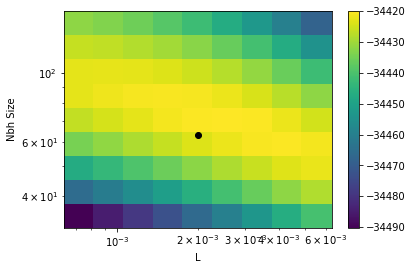

In [14]:
surface = np.array(res).reshape((10, 10))
pylab.pcolormesh(L_list, nbh_list, surface)
#pylab.pcolormesh(, a_list, surface)
pylab.xscale('log')
pylab.yscale('log')
pylab.xlabel('L')
pylab.ylabel('Nbh Size')
pylab.colorbar()
#pylab.plot(25, 0.1, 'ko', linewidth=5)
pylab.plot(0.002, 62.8, 'ko', linewidth=5)

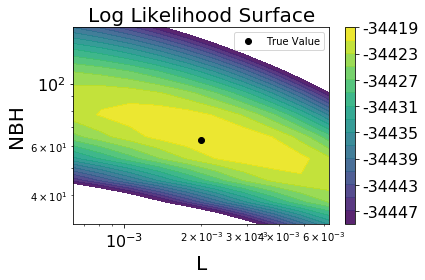

In [18]:
pylab.figure()
levels = np.arange(max(res) - 30, max(res) + 1, 2)  # Every two likelihood units
#ax=pylab.contourf(l_list, a_list, surface, alpha=0.9, levels=levels)
ax=pylab.contourf(L_list, nbh_list, surface, alpha=0.9,levels=levels)

# plt.clabel(ax, inline=1, fontsize=10)
cb=pylab.colorbar(ax, format="%i")
cb.ax.tick_params(labelsize=16)
pylab.title("Log Likelihood Surface", fontsize=20)
pylab.xlabel("L", fontsize=20) # l
pylab.ylabel("NBH", fontsize=20) # a
pylab.xticks(fontsize=16)
pylab.yticks(fontsize=16)
pylab.xscale('log')
#pylab.tick_params(axis='both', which='both', bottom='off', 
#                    top='off', labelbottom='off', right='off', left='off', labelleft='off')
pylab.yscale('log')
pylab.plot(0.002, 62.8, 'ko', linewidth=5, label="True Value")
pylab.legend()
pylab.tight_layout()
pylab.show()

In [ ]:
aa, ll = 1, 1
kk = np.array([1, 1, 0.8])   #a,l,c
kk = np.append(kk, mean_paramss)
print("Hyper Parameters: ")
print(kk[:10])

In [ ]:
# Single Run; where optimization is computed.
with tf.Session(config=config) as sess:
    #sess.run(tf.initialize_all_variables())
    sess.run(tf.global_variables_initializer())   # Update by Harald
    
    for i in range(5):
        sess.run(opt_op, {hyper_params: kk})
    r = sess.run([f_tot, F, logdet, margL, K], {hyper_params: kk})
print("f_tot:")
print(r[0])
print("F:")
print(r[1])
print("logdet:")
print(r[2])
print("Marg.L")
print(r[3])
print("K")
print(r[4])

In [ ]:
x, y, z = X_data[:nr_inds, 0], X_data[:nr_inds, 1], r[0][:,1]
#x=np.linspace(0, 1, 20)
#print(len(x))
print(len(x))
print(len(y))
print(len(z))

In [ ]:
pylab.pcolormesh(x, y, z.reshape(21,21))
pylab.colorbar()

In [ ]:
x.shape

In [ ]:
y.shape

In [ ]:
z.shape

In [ ]:
###### The Full Kernel:
# Not used in actual code anymore
def full_kernel_function(coords, l, a, c, sigma_sqrd=0):
    '''Return barrier Kernel - describing reduced correlation across barrier
    and increased correlation next to barrier. Coords is nx2 Numpy array.
    Barrier is assumed to be at x=0'''
    x = coords[:, 0]  # Extracts x-coords
    nr_inds=tf.size(x)
    
    mask = tf.constant([-1.0, 1.0], dtype=tf.float64) # Mask used for reflecting coordinates
    
    coords_refl = coords * mask[None,:]  # Reflects the x-Coordinate
    
    g = tf.sign(x)  # Calculates Signum of x
    same_side = (g[:,None] * g + 1) / 2  # Whether the x-Values are on the same side
    #print("Same Side Vector: ")
    #print(same_side)
    
    r_sqrd = tf.reduce_sum(((coords[:, None] - coords[None, :]) ** 2), reduction_indices=[2])  # Calculates pairwise Distance
    r_refl_sqrd = tf.reduce_sum(((coords_refl[:, None] - coords[None, :]) ** 2), reduction_indices=[2])  # Calculates the reflected Distance 
    
    # Calculate the normal Kernel:
    cov_mat = a * tf.exp(-r_sqrd / (2. * l ** 2))  # Calculate the co-variance matrix. Added diagonal term
    cov_mat_refl = a * tf.exp(-r_refl_sqrd / (2. * l ** 2))  # Calculate the covariance matrix for reflected coordinates.
    
    # Introduce the Covariance Function due to complete correlation
    K1 = sigma_sqrd * tf.ones((nr_inds,nr_inds),dtype=tf.float64)
    
    # Calculate the full Covariance Matrix
    K = same_side * (cov_mat + c * cov_mat_refl) + (1 - same_side) * (1 - c) * cov_mat + K1
    
    #print("Covariance Matrix: ")
    #print(cov_tot)
    #print("Eigenvalues: ")
    #print(np.linalg.eig(cov_mat)[0])
    return K

def rbf_kernel_function(coords, l, a):
    '''The usual exponential kernel function'''
    K = a * tf.exp(-tf.reduce_sum(((coords[:, None] - coords[None, :]) ** 2) / (2 * l**2), reduction_indices=[2]))
    return K

In [ ]:
with tf.device('/cpu:0'):
    X = tf.Variable(dtype=tf.float64, initial_value = 0, trainable=False)

In [ ]:
with tf.device('/cpu:0'):   # For debugging
    c = 3*tf.ones((5,2), dtype=tf.float64)
    d = tf.constant([-1,1], dtype=tf.float64)
    e = c * d[None,:]
    f = c[:,0]
    g = tf.ones((5,5))
    h = tf.size(g[:,0])

In [ ]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    r=sess.run([c,d,e,f,g,h])

In [ ]:
r[-1]

In [ ]:
tf.__version__

In [ ]:
logdet

In [ ]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    r = sess.run(logdet, {a: 1.0, l: 1.0})

In [ ]:
kc = fac_kernel("RBFBarrierK")
coords = np.array([[i,j] for i in xrange(-20,24,8) for j in xrange(-20,24,8)])
kernel = kc.calc_kernel(coords)
plt.figure()
plt.plot(kernel[0,:6], label = "Same Side")
plt.plot(kernel[0,::6], label = "Different Sides")
plt.legend()
plt.show()

In [ ]:
KC = fac_kernel(kernel_type)     # Initializes the Kernel Calculator
KC.give_parameter_names()
#KC.give_parameters()

In [ ]:
coords = np.array([[i,j] for i in range(10) for j in range(5)])